# Table of Contents
1. Data Loading
2. Data Exploration
3. Data Visualization
4. Data Preprocessing and Feature Engineering
5. Model Building
6. Submission

# 1. Data Loading

In [1]:
#load packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
#load the training dataset
train_dataset = pd.read_csv('loan train.csv')

# 2. Data Exploration

In [3]:
train_dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
train_dataset.shape

(614, 13)

In [5]:
#statistics of training dataset numerical features
train_dataset.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [6]:
train_dataset.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

# 3. Data Visualization 

In [7]:
#view columns 
train_dataset.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

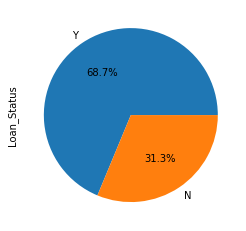

In [8]:
#check Loan Status distribution
train_dataset['Loan_Status'].value_counts().plot(kind='pie',autopct='%1.1f%%')

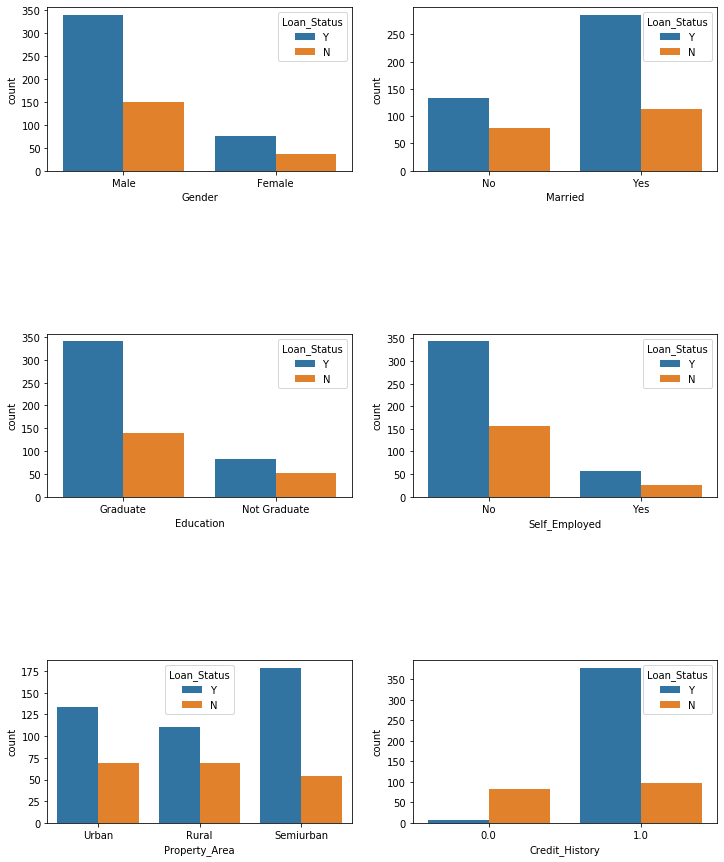

In [9]:
#Check categorical features distribution
categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area','Credit_History']

fig,axes = plt.subplots(3,2,figsize=(12,15))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=train_dataset,hue='Loan_Status',ax=axes[row,col])


plt.subplots_adjust(hspace=1)

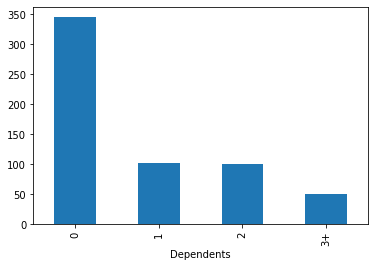

In [10]:
#check dependents distribution
train_dataset.groupby(['Dependents'])['Loan_Status'].count().plot(kind='bar')

C:\Users\Riddhi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


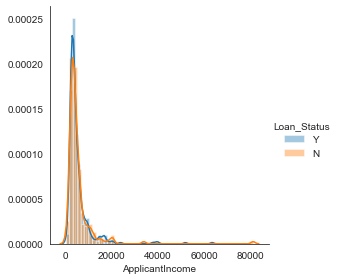

In [11]:
#check Applicant Income and Loan Status
sns.set_style("white")
sns.FacetGrid(train_dataset, hue='Loan_Status',size=4).map(sns.distplot,"ApplicantIncome").add_legend()

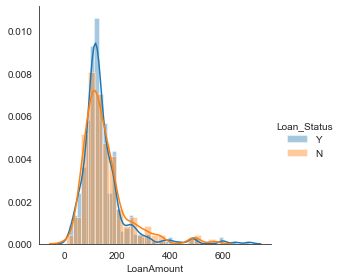

In [12]:
#check loan amount and loan status
sns.set_style("white")
sns.FacetGrid(train_dataset, hue='Loan_Status',size=4).map(sns.distplot,"LoanAmount").add_legend()

# 4. Data Preprocessing and Feature Engineering

In [13]:
# Check for null values in train
percent_missing = train_dataset.isnull().sum() * 100 / len(train_dataset)
missing_value_train = pd.DataFrame({'column_name': train_dataset.columns,
                                 'percent_missing': percent_missing})
missing_value_train.sort_values('percent_missing', ascending=False,inplace=True)
missing_value_train

,column_name,percent_missing
Credit_History,Credit_History,8.143322
Self_Employed,Self_Employed,5.211726
LoanAmount,LoanAmount,3.583062
Dependents,Dependents,2.442997
Loan_Amount_Term,Loan_Amount_Term,2.280130
Gender,Gender,2.117264
Married,Married,0.488599
Loan_ID,Loan_ID,0.000000
Education,Education,0.000000
ApplicantIncome,ApplicantIncome,0.000000


In [14]:
#change missing values
train_dataset['Gender'].fillna('Male', inplace=True)
train_dataset['Married'].fillna('Yes', inplace=True)
train_dataset['Self_Employed'].fillna('No', inplace=True)
train_dataset['LoanAmount'].fillna(train_dataset['LoanAmount'].mean(), inplace=True)
train_dataset['Credit_History'].fillna(2, inplace=True)
train_dataset['Loan_Amount_Term'].fillna(train_dataset['Loan_Amount_Term'].mean(), inplace=True)

In [15]:
#drop Loan ID
train_dataset = train_dataset.drop('Loan_ID',axis=1)

In [16]:
#one hot encoding == loan amount term
train_dataset['Very_Short_Term'] = train_dataset['Loan_Amount_Term'].map(lambda t: 1 if t<=60 else 0)
train_dataset['Short_Term'] = train_dataset['Loan_Amount_Term'].map(lambda t: 1 if t>60 and t<180 else 0)
train_dataset['Long_Term'] = train_dataset['Loan_Amount_Term'].map(lambda t: 1 if t>=180 and t<=300  else 0)
train_dataset['Very_Long_Term'] = train_dataset['Loan_Amount_Term'].map(lambda t: 1 if t>300 else 0)
train_dataset.drop('Loan_Amount_Term', axis=1, inplace=True)

In [17]:
#one hot encoding == credit history
train_dataset['Credit_History_Bad'] = train_dataset['Credit_History'].map(lambda c: 1 if c==0 else 0)
train_dataset['Credit_History_Good'] = train_dataset['Credit_History'].map(lambda c: 1 if c==1 else 0)
train_dataset['Credit_History_Unknown'] = train_dataset['Credit_History'].map(lambda c: 1 if c==2 else 0)
train_dataset.drop('Credit_History', axis=1, inplace=True)

In [18]:
#create total income feature
train_dataset['TotalIncome'] = train_dataset['ApplicantIncome']+ train_dataset['CoapplicantIncome']

In [19]:
#create dummy variables for categorical features
train_dataset = pd.get_dummies(train_dataset,drop_first=True)
train_dataset.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Very_Short_Term,Short_Term,Long_Term,Very_Long_Term,Credit_History_Bad,Credit_History_Good,Credit_History_Unknown,...,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,5849,0.0,146.412162,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,1,1
1,4583,1508.0,128.000000,0,0,0,1,0,1,0,...,1,1,1,0,0,0,0,0,0,0
2,3000,0.0,66.000000,0,0,0,1,0,1,0,...,1,1,0,0,0,0,1,0,1,1
3,2583,2358.0,120.000000,0,0,0,1,0,1,0,...,1,1,0,0,0,1,0,0,1,1
4,6000,0.0,141.000000,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,1,1


In [20]:
#get column names in list
cols=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome', 'Gender_Male',
       'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 
       'Very_Short_Term', 'Short_Term', 'Long_Term', 'Very_Long_Term',
       'Credit_History_Bad', 'Credit_History_Good', 'Credit_History_Unknown','Loan_Status_Y',]

In [21]:
#put columns in dataframe
df=pd.DataFrame(train_dataset,columns=cols)

# 5. Model Building

In [22]:
#set x to equal columns and y to equal loan status
X = df.iloc[:,:-1].values
y = df['Loan_Status_Y'].values

In [23]:
#xgboost classifier model
parameters ={"learning_rate"    : [ 0.1,0.20,0.30 ] ,
             "max_depth"        : [ 6,7 ],
             "gamma"            : [ 0.0],
             "random_state"     : [1,2,3,4]}
classifier = XGBClassifier(n_estimators=50)
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=parameters,
                           scoring='accuracy',
                           cv=10,
                           n_jobs=1)
model = grid_search.fit(X, y)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

classifier= XGBClassifier(n_estimators=30, max_depth=6,learning_rate=0.1,gamma=0,random_state=1)
classifier.fit(X,y)

y_pred=model.predict(X)

In [24]:
#check accuracy of model == 90.71% accuracy
accuracy = metrics.accuracy_score(y_pred, y)
print('Accuracy:',  accuracy)

Accuracy: 0.9071661237785016


# 6. Submission

In [25]:
#load the test dataset
test_dataset=pd.read_csv('loan test.csv')

In [26]:
#add total income as additional feature
test_dataset['TotalIncome'] = test_dataset['ApplicantIncome']+ test_dataset['CoapplicantIncome']

In [27]:
#set df2 to include loan ID and drop loan ID from test dataset
df2=pd.DataFrame()
df2['Loan_ID']=test_dataset['Loan_ID']
test_dataset=test_dataset.drop('Loan_ID',axis=1)

In [28]:
# Check for null values in train
percent_missing = test_dataset.isnull().sum() * 100 / len(test_dataset)
missing_value_test = pd.DataFrame({'column_name': test_dataset.columns,
                                 'percent_missing': percent_missing})
missing_value_test.sort_values('percent_missing', ascending=False,inplace=True)
missing_value_test

,column_name,percent_missing
Credit_History,Credit_History,7.901907
Self_Employed,Self_Employed,6.267030
Gender,Gender,2.997275
Dependents,Dependents,2.724796
Loan_Amount_Term,Loan_Amount_Term,1.634877
LoanAmount,LoanAmount,1.362398
Married,Married,0.000000
Education,Education,0.000000
ApplicantIncome,ApplicantIncome,0.000000
CoapplicantIncome,CoapplicantIncome,0.000000


In [29]:
#change missing values
test_dataset['Gender'].fillna('Male', inplace=True)
test_dataset['Married'].fillna('Yes', inplace=True)
test_dataset['Self_Employed'].fillna('No', inplace=True)
test_dataset['LoanAmount'].fillna(test_dataset['LoanAmount'].mean(), inplace=True)
test_dataset['Credit_History'].fillna(2, inplace=True)
test_dataset['Loan_Amount_Term'].fillna(test_dataset['Loan_Amount_Term'].mean(), inplace=True)

In [30]:
#change dependents to be object
test_dataset['Dependents']=test_dataset['Dependents'].astype(object)

In [31]:
#one hot encoding
test_dataset['Very_Short_Term'] = test_dataset['Loan_Amount_Term'].map(lambda t: 1 if t<=60 else 0)
test_dataset['Short_Term'] = test_dataset['Loan_Amount_Term'].map(lambda t: 1 if t>60 and t<180 else 0)
test_dataset['Long_Term'] = test_dataset['Loan_Amount_Term'].map(lambda t: 1 if t>=180 and t<=300  else 0)
test_dataset['Very_Long_Term'] = test_dataset['Loan_Amount_Term'].map(lambda t: 1 if t>300 else 0)
test_dataset.drop('Loan_Amount_Term', axis=1, inplace=True)

In [32]:
#one hot encoding
test_dataset['Credit_History_Bad'] = test_dataset['Credit_History'].map(lambda c: 1 if c==0 else 0)
test_dataset['Credit_History_Good'] = test_dataset['Credit_History'].map(lambda c: 1 if c==1 else 0)
test_dataset['Credit_History_Unknown'] = test_dataset['Credit_History'].map(lambda c: 1 if c==2 else 0)
test_dataset.drop('Credit_History', axis=1, inplace=True)

In [33]:
#create dummy variables for categorical features
test_dataset=pd.get_dummies(test_dataset,drop_first=True)

In [34]:
test_dataset.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,TotalIncome,Very_Short_Term,Short_Term,Long_Term,Very_Long_Term,Credit_History_Bad,Credit_History_Good,Credit_History_Unknown,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,5720,0,110.0,5720,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1
1,3076,1500,126.0,4576,0,0,0,1,0,1,0,1,1,1,0,0,0,0,0,1
2,5000,1800,208.0,6800,0,0,0,1,0,1,0,1,1,0,1,0,0,0,0,1
3,2340,2546,100.0,4886,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,1
4,3276,0,78.0,3276,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1


In [35]:
#put features in list
cols=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome','Gender_Male',
       'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 
       'Very_Short_Term', 'Short_Term', 'Long_Term', 'Very_Long_Term',
       'Credit_History_Bad', 'Credit_History_Good', 'Credit_History_Unknown']

In [36]:
#put columns in dataframe
test_dataset=pd.DataFrame(test_dataset,columns=cols)

In [37]:
#set x to equal columns
X=test_dataset.iloc[:,:].values

In [38]:
#add loan status to dataframe
df2['Loan_Status']=grid_search.predict(X)

In [39]:
df2['Loan_Status'] = df2['Loan_Status'].map({1:'Y', 0:'N'}).astype(str)

In [40]:
df2.head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y


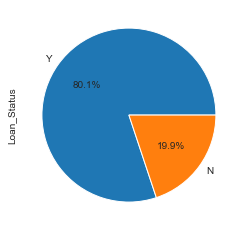

In [41]:
#check Loan Status distribution
df2['Loan_Status'].value_counts().plot(kind='pie',autopct='%1.1f%%')

In [42]:
#put results in final csv
df2.to_csv('Final Submission.csv',index=False)